<a href="https://colab.research.google.com/github/Fritz302/data-science/blob/main/FritKokiU9proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import torch
import numpy as np
from torch import nn
import pandas as pd
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

I'm using data from the Richup games my friends and I have played over this year. Richup is basically an online monopoly and these stats include the match number, player, their starting position and finishing position, the most profitable country, and their amount of turns.

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/Fritz302/data-science/refs/heads/main/Richup%20Data%20Formatted%20-%20Sheet1.csv")
data.columns = ['Match', 'Player', 'Score1', 'Score2', 'Country', 'Target']

In [4]:
data

,Match,Player,Score1,Score2,Country,Target
0,1,you diggin in me,3,4,USA,173
1,1,Rick,6,2,Italy,217
2,1,kumalala,2,1,Germany,217
3,1,Nukem,1,6,Airports,151
4,1,jahk tuah,4,5,NaN,154
...,...,...,...,...,...,...
168,29,you diggin in me,1,1,"France, Brazil",168
169,29,Rick,3,5,N/A w Germany,128
170,29,kumalala,6,4,N/A w USA,147
171,29,Nukem,4,6,NaN,134


In [5]:
#cleans up the data
data.replace('DNP', pd.NA, inplace=True)
data['Score1'] = pd.to_numeric(data['Score1'], errors='coerce')
data['Score2'] = pd.to_numeric(data['Score2'], errors='coerce')
data['Target'] = pd.to_numeric(data['Target'], errors='coerce')
data.dropna(subset=['Target'], inplace=True)

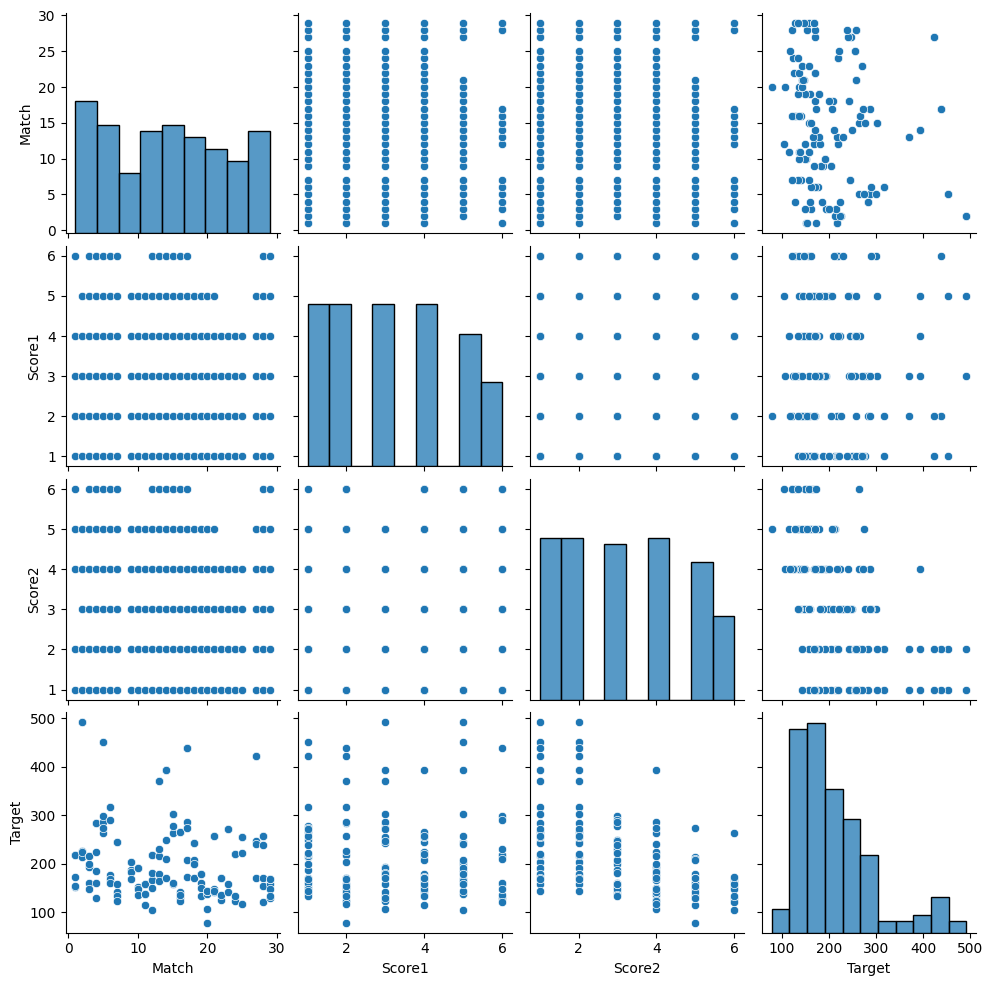

In [11]:
sns.pairplot(data)

This is not looking too great but I do see some trends and I really want to use this data so I'm going to procede.

In [6]:
#specifies predictors and outputs
features = ['Score1', 'Score2', 'Country']
X = data[features]
y = data['Target']

In [23]:
#fills missing numbers
numeric_features = ['Score1', 'Score2']
categorical_features = ['Country']

preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), numeric_features),

    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_features)
])

#Transforms data into PyTorch tensors
X_processed = preprocessor.fit_transform(X)
X_tensor = torch.tensor(X_processed.toarray() if hasattr(X_processed, 'toarray') else X_processed, dtype=torch.float64)
y_tensor = torch.tensor(y.values, dtype=torch.float64).unsqueeze(1)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2)
#80% for training, 20% for testing

In [14]:
#simple linear model with a bunch of inputs but only one output
model = nn.Linear(X_train.shape[1], 1, dtype=torch.float64)
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
#uses Mean Squared Error as the loss function and SGD to optimize

In [15]:
epochs = 50 #trains model 50 times
for epoch in range(epochs):
    model.train()
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        test_pred = model(X_test)
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 5 == 0:
        print(f"Epoch {epoch}: Train loss = {loss.item():.4f}, Test loss = {test_loss.item():.4f}")

Epoch 0: Train loss = 51987.1978, Test loss = 36950.5459
Epoch 5: Train loss = 9029.0185, Test loss = 9747.6584
Epoch 10: Train loss = 5462.4936, Test loss = 6680.1711
Epoch 15: Train loss = 5058.7072, Test loss = 6152.6537
Epoch 20: Train loss = 4934.5652, Test loss = 6015.7339
Epoch 25: Train loss = 4850.4938, Test loss = 5972.3251
Epoch 30: Train loss = 4782.4463, Test loss = 5960.1567
Epoch 35: Train loss = 4725.4259, Test loss = 5961.2060
Epoch 40: Train loss = 4676.8334, Test loss = 5968.9304
Epoch 45: Train loss = 4634.8236, Test loss = 5980.4240


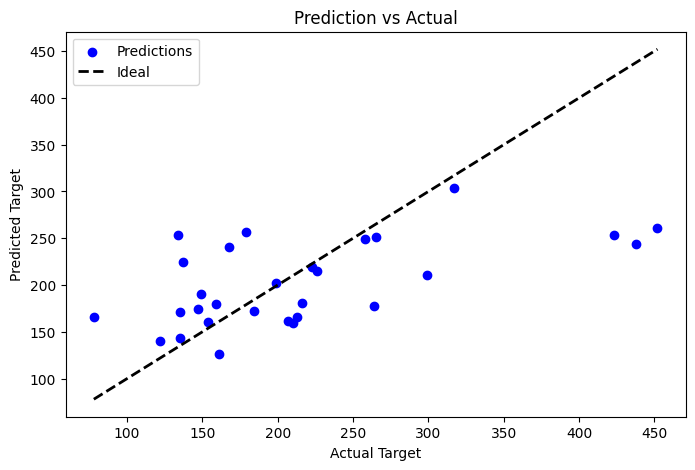

In [16]:
#plots it on da graph
def plot_predictions(X, y_true, y_pred):
    plt.figure(figsize=(8, 5))
    plt.scatter(y_true, y_pred, c='blue', label='Predictions')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2, label='Ideal')
    plt.xlabel('Actual Target')
    plt.ylabel('Predicted Target')
    plt.title('Prediction vs Actual')
    plt.legend()
    plt.show()

plot_predictions(X_test, y_test, test_pred)

I mean, it's kind of getting it but I'll add another predictor in an attempt to improve it.

In [34]:
#specifies predictors and outputs
features = ['Match', 'Score1', 'Score2', 'Country']  #added match
X = data[features]
y = data['Target']

In [35]:
#fills missing numbers
numeric_features = ['Score1', 'Score2']
categorical_features = ['Country']

preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), numeric_features),

    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_features)
])

#Transforms data into PyTorch tensors
X_processed = preprocessor.fit_transform(X)
X_tensor = torch.tensor(X_processed.toarray() if hasattr(X_processed, 'toarray') else X_processed, dtype=torch.float64)
y_tensor = torch.tensor(y.values, dtype=torch.float64).unsqueeze(1)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2)
#80% for training, 20% for testing

In [37]:
#simple linear model with a bunch of inputs but only one output
model = nn.Linear(X_train.shape[1], 1, dtype=torch.float64)
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
#uses Mean Squared Error as the loss function and SGD to optimize

In [41]:
epochs = 50 #trains model 50 times
for epoch in range(epochs):
    model.train()
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        test_pred = model(X_test)
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 5 == 0:
        print(f"Epoch {epoch}: Train loss = {loss.item():.4f}, Test loss = {test_loss.item():.4f}")

Epoch 0: Train loss = 4183.4342, Test loss = 6984.8626
Epoch 5: Train loss = 4164.1036, Test loss = 7023.4595
Epoch 10: Train loss = 4145.8366, Test loss = 7060.8778
Epoch 15: Train loss = 4128.5415, Test loss = 7097.1207
Epoch 20: Train loss = 4112.1376, Test loss = 7132.1972
Epoch 25: Train loss = 4096.5538, Test loss = 7166.1209
Epoch 30: Train loss = 4081.7266, Test loss = 7198.9090
Epoch 35: Train loss = 4067.5993, Test loss = 7230.5813
Epoch 40: Train loss = 4054.1207, Test loss = 7261.1602
Epoch 45: Train loss = 4041.2448, Test loss = 7290.6697


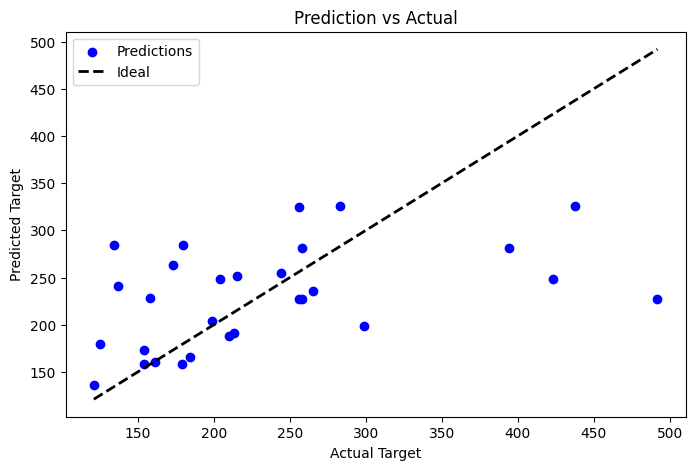

In [42]:
#plots it on da graph
def plot_predictions(X, y_true, y_pred):
    plt.figure(figsize=(8, 5))
    plt.scatter(y_true, y_pred, c='blue', label='Predictions')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2, label='Ideal')
    plt.xlabel('Actual Target')
    plt.ylabel('Predicted Target')
    plt.title('Prediction vs Actual')
    plt.legend()
    plt.show()

plot_predictions(X_test, y_test, test_pred)

Not much improvement but oh well. I'm kind of out of time so I'll stick with this model. I wish I would've had more time to work on this because I didn't even get to use all the variables.